Flex all X-axes joints of the robox.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from os.path import dirname
sys.path.append(os.path.join(os.getcwd(), '..'))

In [4]:
import cv2
import pybullet as p
import numpy as np
import pylab

from opencv.opencv_tools import save
from pyb.pybullet_robot import PyBulletRobot

In [5]:
r = PyBulletRobot(render=True)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [6]:
from opencv.opencv_pose import Pose
pose = Pose(r.W, r.H, '../pyb/cal.npz', r.D)

In [14]:
phiss, camps, tvecs = [], [], []

PHIX_LOW, PHIX_HIGH = np.pi/12, np.pi/6
DPHI = (PHIX_HIGH - PHIX_LOW) / 25

first_phi, last_phi = None, None

def rstep_1x(phix):
    phis = np.array([[phix, 0], [phix, 0], [phix, 0], [phix, 0]])
    r.step(phis)
    return phis
    
for phix in np.arange(PHIX_LOW, PHIX_HIGH+DPHI, DPHI):
    phis = rstep_1x(phix)                  
    img, cam_p, _, _, _ = r.getHeadcam()
    retval, rvec, tvec, _ = pose.findChessboardRTVecs(img)
    if retval:
        camps.append(cam_p)
        tvecs.append(tvec)
        phiss.append(phis)
        
        if first_phi is None:
            first_phi = last_phi = phix
            print("first_phi: %f" % first_phi)
        elif last_phi < phix:
            last_phi = phix
            
print("last_phi: %f" % last_phi)


phiss = np.array(phiss)
camps = np.array(camps)
tvecs = np.array(tvecs)
print(camps.shape)

first_phi: 0.324631
last_phi: 0.439823
(12, 3)


#### head moves down on Z world axis

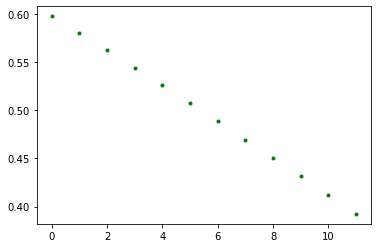

In [15]:
plt.plot(camps[:,2], 'g.')

#### target Y component of translation vector sweeps from 0.6 to -0.6

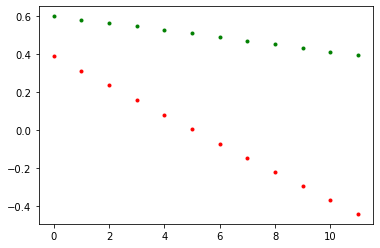

In [19]:
plt.plot(camps[:,2], 'g.', tvecs[:,1], 'r.')

#### headcam sways horizontally a tiny bit

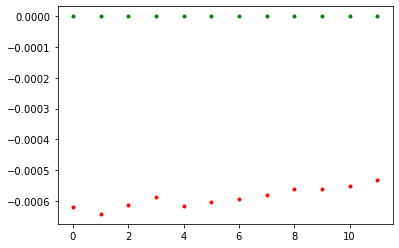

In [20]:
plt.plot(camps[:,1], 'g.', tvecs[:,0], 'r.')

#### headcam gets closer to the target

In [29]:
camds = []
for cam_p in camps:
    cam_d = np.sqrt(np.sum(np.square(np.array(cam_p) - np.array([2, 0, 0.59])), axis=0))
    camds.append(cam_d)
camds = np.array(camds)

In [30]:
tvecds = np.sqrt(np.sum(np.square(tvecs), axis=1)).ravel()

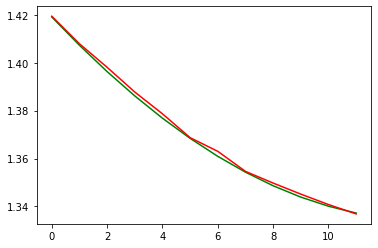

In [31]:
plt.plot(camds, 'g', tvecds, 'r')

In [32]:
tvecds

array([1.41940687, 1.40790607, 1.39807363, 1.38775289, 1.37865122,
       1.36869184, 1.36298814, 1.35461262, 1.34973841, 1.34512216,
       1.34077017, 1.33685953])

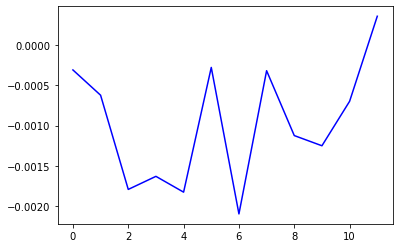

In [33]:
plt.plot(camds - tvecds, 'b')

####  Z component of translation vector reaches it peak and goes away

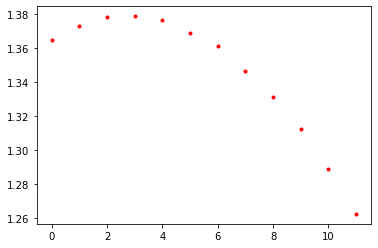

In [35]:
plt.plot(tvecs[:,2], 'r.')

In [36]:
r.close()

*** PyBulletRobot() closed ***
